# Clinical Trial Named Entity Recognition (NER)

## Imports and Initial Setup

In [1]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=4ea0edac4d17d2386884f714cfe8f5d40d51b905da0665f8b449050eec7599d6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from huggingface_hub import HfApi, HfFolder
from google.colab import userdata

import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFBertForTokenClassification, BertTokenizerFast

from seqeval.metrics import classification_report

## Data Import, EDA and Preprocessing

- Processed 'tags' column to extract labeled entities and text

In [4]:
def extract_entities(row):
    entities = []
    tags = row['tags']
    text = row['text']

    if pd.isna(tags) or pd.isna(text):
        return entities

    tag_list = tags.split(',')

    for tag in tag_list:
        if tag.strip():
            start, end, label = tag.split(':')
            start_idx, end_idx = int(start)-1, int(end)-1 # adjusting index for exact match
            entity = {
                'start_idx': start_idx,
                'end_idx': end_idx,
                'label': label,
                'extracted_text': text[start_idx:end_idx]
            }
            entities.append(entity)

    return entities

def load_and_clean_data(dataset):

    if isinstance(dataset, str):
      df = pd.read_excel(dataset)
    elif isinstance(dataset, pd.DataFrame):
      df = dataset.copy()

    df['entities'] = df.apply(extract_entities, axis=1)
    df.dropna(subset=['text'],inplace=True)
    df.drop('Unnamed: 0',axis=1, inplace=True)

    return df

In [5]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Clinic_Trail_NER/"

G1_df = load_and_clean_data(folder_path+"G1.xlsx")
G2_df = load_and_clean_data(folder_path+"G2.xlsx")
G3_df = load_and_clean_data(folder_path+"G3.xlsx")

In [6]:
print(G1_df.info(), G2_df.info(), G3_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        7356 non-null   object
 1   tags      7356 non-null   object
 2   text      7356 non-null   object
 3   entities  7356 non-null   object
dtypes: object(4)
memory usage: 230.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6454 entries, 0 to 6454
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        6454 non-null   object
 1   tags      6454 non-null   object
 2   text      6454 non-null   object
 3   entities  6454 non-null   object
dtypes: object(4)
memory usage: 252.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        6277 non-null   object
 1   tags      6277 non-null   ob

- One NA value found in G2's text column which was dropped in load_and_clean_data()

In [7]:
def count_label_distribution(series):
    flattened_data = [item for sublist in series for item in sublist]
    labels = pd.Series([item['label'] for item in flattened_data])
    label_counts = labels.value_counts(normalize=True)
    print(label_counts)

print("Label distribution in Task 1:")
count_label_distribution(G1_df['entities'])
print("\nLabel distribution in Task 2:")
count_label_distribution(G2_df['entities'])
print("\nLabel distribution in Task 3:")
count_label_distribution(G3_df['entities'])

Label distribution in Task 1:
treatment          0.457905
chronic_disease    0.386941
cancer             0.132829
allergy_name       0.022325
Name: proportion, dtype: float64

Label distribution in Task 2:
treatment          0.427779
chronic_disease    0.403769
cancer             0.142922
allergy_name       0.025530
Name: proportion, dtype: float64

Label distribution in Task 3:
treatment          0.451388
chronic_disease    0.389276
cancer             0.129198
allergy_name       0.030138
Name: proportion, dtype: float64


- Label distribution is highly imbalanced, with very few datapoints for allergy category

In [ ]:
def analyze_sequence_lengths(df):

    sequence_lengths = []
    for text in df['text']:
        tokens = tokenizer.tokenize(text)
        sequence_lengths.append(len(tokens))

    plt.boxplot(sequence_lengths)
    plt.xlabel("Sequence Length")
    plt.ylabel("Count")
    plt.show()

    print("Average sequence length:", sum(sequence_lengths) / len(sequence_lengths))
    print("Maximum sequence length:", max(sequence_lengths))

In [15]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

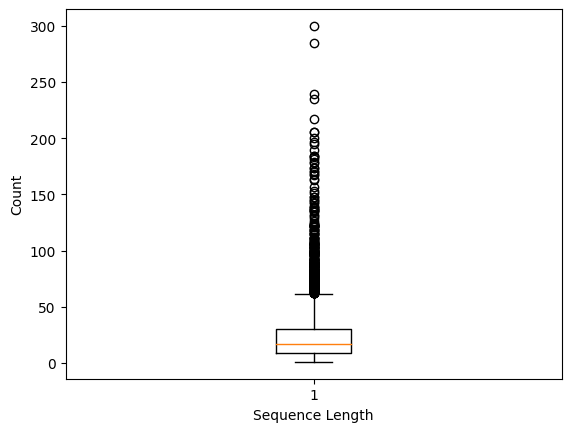

Average sequence length: 23.48341489940185
Maximum sequence length: 300


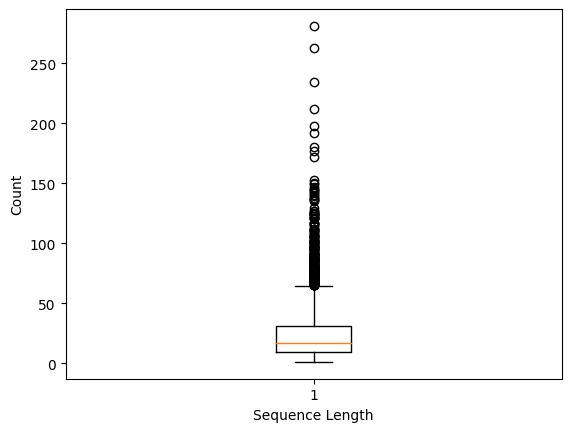

Average sequence length: 23.487449643631855
Maximum sequence length: 281


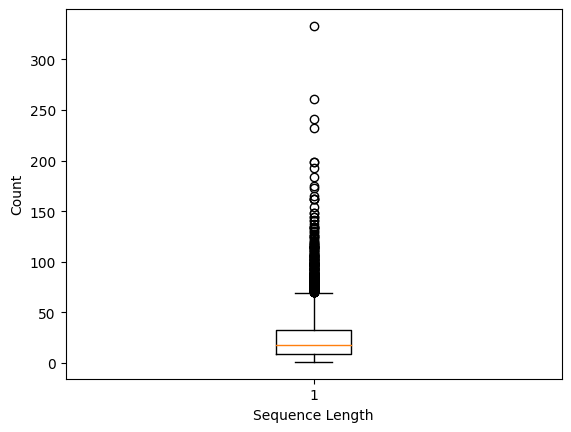

Average sequence length: 24.375338537517923
Maximum sequence length: 333
None None None


In [ ]:
print(analyze_sequence_lengths(G1_df), analyze_sequence_lengths(G2_df), analyze_sequence_lengths(G3_df))

- Very few datapoints where the text's token length is greater than 256.

In [ ]:
def drop_long_sequences(df, tokenizer, max_tokens=256):
    def is_within_limit(text, max_tokens):
        tokens = tokenizer.tokenize(text)
        return len(tokens) <= max_tokens

    filtered_df = df[df['text'].apply(lambda x: is_within_limit(x, max_tokens))]

    print(f"Dropped {len(df) - len(filtered_df)} rows with more than {max_tokens} tokens.")
    return filtered_df

In [ ]:
G1_df = drop_long_sequences(G1_df, tokenizer, max_tokens=256)
G2_df = drop_long_sequences(G2_df, tokenizer, max_tokens=256)
G3_df = drop_long_sequences(G3_df, tokenizer, max_tokens=256)

Dropped 2 rows with more than 256 tokens.
Dropped 2 rows with more than 256 tokens.
Dropped 2 rows with more than 256 tokens.


In [ ]:
print("Label distribution in Task 1:")
count_label_distribution(G1_df['entities'])
print("\nLabel distribution in Task 2:")
count_label_distribution(G2_df['entities'])
print("\nLabel distribution in Task 3:")
count_label_distribution(G3_df['entities'])

Label distribution in Task 1:
treatment          0.457703
chronic_disease    0.387045
cancer             0.132913
allergy_name       0.022339
Name: proportion, dtype: float64

Label distribution in Task 2:
treatment          0.427526
chronic_disease    0.403521
cancer             0.143347
allergy_name       0.025606
Name: proportion, dtype: float64

Label distribution in Task 3:
treatment          0.451168
chronic_disease    0.389736
cancer             0.128916
allergy_name       0.030180
Name: proportion, dtype: float64


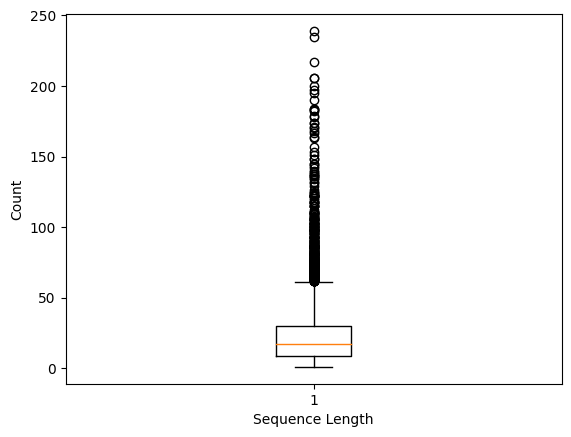

Average sequence length: 23.410252923579005
Maximum sequence length: 239


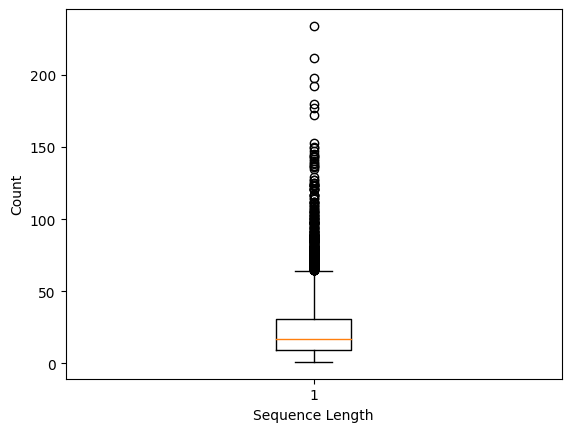

Average sequence length: 23.410415375077495
Maximum sequence length: 234


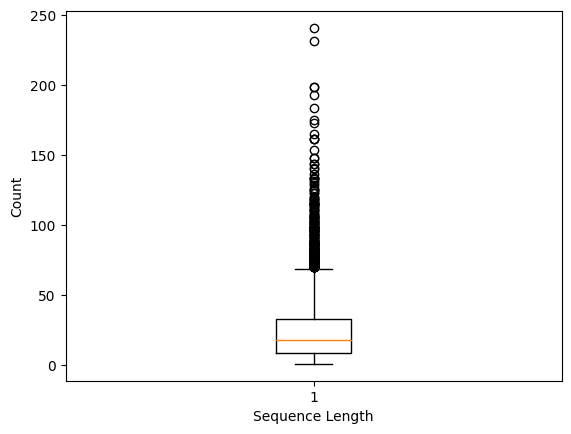

Average sequence length: 24.28844621513944
Maximum sequence length: 241
None None None


In [ ]:
print(analyze_sequence_lengths(G1_df), analyze_sequence_lengths(G2_df), analyze_sequence_lengths(G3_df))

- Only 2 rows had text exceeding 256 tokens; these were dropped
- Max input length set to 256 tokens to accommodate all remaining datapoints

## Data Preparation and Encoding

- Data split into 80-20 train-test, with further 80-20 split of training data for validation
- Implemented BIO (Beginning, Inside, Outside) tagging scheme for BERT-based NER

In [14]:
def train_val_test_split(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # train_test split
    temp_train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # validation split
    train_df, val_df = train_test_split(temp_train_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    print(f"Training set size: {train_df.shape}")
    print(f"Val size: {val_df.shape}")
    print(f"Test set size: {test_df.shape}")
    return train_df, val_df, test_df

def encode_examples(df, tokenizer, label_map):
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for _, row in df.iterrows():
        text = row['text']
        entities = row['entities']

        tokenized_input = tokenizer(text, truncation=True, padding='max_length', max_length=256, return_offsets_mapping=True)
        input_ids = tokenized_input['input_ids']
        attention_mask = tokenized_input['attention_mask']
        offset_mapping = tokenized_input['offset_mapping']

        labels = ['O'] * len(input_ids)

        for entity in entities:
            start_idx = entity['start_idx']
            end_idx = entity['end_idx']
            label = entity['label']

            entity_started = False
            for idx, (start, end) in enumerate(offset_mapping):
                if start_idx <= start < end_idx and end != 0:
                    if not entity_started:
                        labels[idx] = f"B-{label}"
                        entity_started = True
                    else:
                        labels[idx] = f"I-{label}"
                elif end < start_idx:
                    entity_started = False

        all_input_ids.append(input_ids)
        all_attention_masks.append(attention_mask)
        all_labels.append([label_map[label] for label in labels])

    return tf.data.Dataset.from_tensor_slices({
    'input_ids': tf.constant(all_input_ids),
    'attention_mask': tf.constant(all_attention_masks),
    'labels': tf.constant(all_labels)
    })

- Validating the encoding for 1 sample from train set.

In [ ]:
label_map = {
    "O": 0,
    "B-treatment": 1, "I-treatment": 2,
    "B-chronic_disease": 3, "I-chronic_disease": 4,
    "B-cancer": 5, "I-cancer": 6,
    "B-allergy_name": 7, "I-allergy_name": 8
}
id2label = {v: k for k, v in label_map.items()}

train_df, val_df, test_df = train_val_test_split(G1_df)

train_dataset = encode_examples(train_df, tokenizer, label_map)

train_dataset_list = list(train_dataset.as_numpy_iterator())

ind = 4
print(train_df.iloc[ind, 2])
print(train_df.iloc[ind, 3])

input_ids = train_dataset_list[ind]['input_ids']
print("Tokens:", tokenizer.convert_ids_to_tokens(input_ids))

print(label_map)

labels = train_dataset_list[ind]['labels']
print("Labels:", labels)
print("Label names:", [id2label[label] for label in labels])

Training set size: (4706, 4)
Val size: (1177, 4)
Test set size: (1471, 4)
Participation in a prior gene transfer therapy study
[{'start_idx': 19, 'end_idx': 46, 'label': 'treatment', 'extracted_text': 'prior gene transfer therapy'}]
Tokens: ['[CLS]', 'Part', '##ici', '##pation', 'in', 'a', 'prior', 'gene', 'transfer', 'therapy', 'study', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

## Model Training and Evaluation

- Utilizing seqeval library to process the output and calculates the F1 score for all labels.
- Utilized BERT base model for token classification

In [ ]:
def load_compile_model():
    model = TFBertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_map))

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

def train_model(model, train_dataset, val_dataset, retention_dataset=None, epochs=3, batch_size=32):

    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # If retention_dataset is present then adding it to the train set
    if retention_dataset is not None:
        retention_dataset = retention_dataset.batch(batch_size)
        train_dataset = train_dataset.concatenate(retention_dataset)

    # Processing the dataset to proper format
    train_dataset = train_dataset.map(lambda x: (
        {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
        x['labels']
    ))
    val_dataset = val_dataset.map(lambda x: (
        {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
        x['labels']
    ))

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )

    return model

def evaluate_model(model, test_dataset, id2label, batch_size=32):
    print("\nEvaluating Model\n")
    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.map(lambda x: (
        {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
        x['labels']
    ))

    test_results = model.evaluate(test_dataset)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")
    print("*"*40)

    # Evaluation part
    y_true = []
    y_pred = []

    for batch in test_dataset:
        labels = batch[1].numpy()
        outputs = model(batch[0])
        predictions = tf.argmax(outputs.logits, axis=-1).numpy()

        for label, pred in zip(labels, predictions):
            y_true.append([id2label[l] for l in label if l != -100])
            y_pred.append([id2label[p] for p, l in zip(pred, label) if l != -100])

    print(classification_report(y_true, y_pred))
    print("*"*40)

    report = classification_report(y_true, y_pred, output_dict=True)

    # Extracting F1 scores for each entity type
    entity_f1_scores = {}
    for label in ['treatment', 'chronic_disease', 'cancer', 'allergy_name']:
        entity_f1_scores[label] = report[label]['f1-score']

    weighted_avg_f1 = report['weighted avg']['f1-score']

    print("Entity-wise F1 scores:")
    for entity, score in entity_f1_scores.items():
        print(f"{entity}: {score:.4f}")
    print(f"Weighted Average F1 score: {weighted_avg_f1:.4f}")

    return entity_f1_scores, weighted_avg_f1

## Main Training and Helper Function

In [ ]:
## Helper functions
def prepare_data(df, label_map):

    train_df, val_df, test_df = train_val_test_split(df)

    train_dataset = encode_examples(train_df, tokenizer, label_map)
    val_dataset = encode_examples(val_df, tokenizer, label_map)
    test_dataset = encode_examples(test_df, tokenizer, label_map)

    return train_df, val_df, test_df, train_dataset, val_dataset, test_dataset

def upload_to_hub(model, task_name):
    model.save_pretrained(f"/content/drive/MyDrive/DS/Clinic_Trail_NER/{task_name}")

    api = HfApi()
    api.create_repo(repo_id=f"krishnapal2308/{task_name}", exist_ok=True)
    api.upload_folder(
        folder_path=f"/content/drive/MyDrive/DS/Clinic_Trail_NER/{task_name}",
        repo_id=f"krishnapal2308/{task_name}",
        repo_type="model",
    )
    print(f"Model uploaded to https://huggingface.co/krishnapal2308/{task_name}")

def get_all_scores(results):
  score_dict = {'Weighted Average':[]}
  for result in results:
    for entity, score in result[0].items():
      score_dict[entity] = score_dict.get(entity,[])
      score_dict[entity].append(score)
    score_dict['Weighted Average'].append(result[1])
  score_df = pd.DataFrame(score_dict)
  return score_df

## Main
def main(df, model, label_map, retention_df=None):

    _, _, _, train_dataset, val_dataset, test_dataset = prepare_data(df, label_map)
    print("*"*40)
    if retention_df is not None:
        retention_dataset = encode_examples(retention_df, tokenizer, label_map)
    else:
        retention_dataset = None

    model = train_model(model, train_dataset, val_dataset, retention_dataset, epochs=3, batch_size=32)
    print("*"*40)

    id2label = {v: k for k, v in label_map.items()}
    entity_f1_scores, weighted_avg_f1 = evaluate_model(model, test_dataset, id2label, batch_size=32)
    print("*"*40)
    return (entity_f1_scores, weighted_avg_f1), model


## Experimental Setup and Data Sampling

- The sample_balanced_examples function takes a list of dataframes as input and returns a balanced subset of 100 unique samples. It ensures equal representation across label categories (25 samples per category in this case) and avoids duplicates between dataframes

In [8]:
def sample_balanced_examples(dfs, n_samples=100, label_categories=['treatment', 'chronic_disease', 'cancer', 'allergy_name']):
    all_texts = set()
    sampled_df = pd.DataFrame()

    combined_df = pd.concat(dfs).reset_index(drop=True)

    combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Samples per label
    samples_per_label = n_samples // len(label_categories)

    # Sampling rows for each label
    label_samples = {label: [] for label in label_categories}
    for _, row in combined_df.iterrows():
        if row['text'] in all_texts:
            continue
        for entity in row['entities']:
            label = entity['label']
            if label in label_categories and len(label_samples[label]) < samples_per_label:
                label_samples[label].append(row)
                all_texts.add(row['text'])
                break  # Moving to next row after adding it to a label
        if len(all_texts) >= n_samples:
            break

    sampled_rows = [row for label_rows in label_samples.values() for row in label_rows]

    # If less than n_samples then adding more rows randomly
    remaining_rows = combined_df[~combined_df['text'].isin(all_texts)]
    while len(sampled_rows) < n_samples and not remaining_rows.empty:
        row = remaining_rows.iloc[0]
        sampled_rows.append(row)
        all_texts.add(row['text'])
        remaining_rows = remaining_rows.iloc[1:]

    # If more than n_samples then randomly removing extras
    if len(sampled_rows) > n_samples:
        sampled_rows = random.sample(sampled_rows, n_samples)

    sampled_df = pd.DataFrame(sampled_rows)

    # Label Distribution
    label_counts = {}
    for label in label_categories:
        count = 0
        for row in sampled_df['entities']:
            for entity in row:
                if entity['label'] == label:
                    count += 1
        label_counts[label] = count

    print(f"Shape of sampled dataframe: {sampled_df.shape}")
    print(f"Label distribution for sampled dataframe:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
    print()
    return sampled_df

In [ ]:
hf_token = userdata.get('HF_TOKEN')
HfFolder.save_token(hf_token)

base_model = load_compile_model()
## tokenizer initialized in Data Loading, EDA and Preprocessing while counting tokens

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
T1_samples = sample_balanced_examples([G1_df])

T2_samples = sample_balanced_examples([G1_df, G2_df])

# T3_samples = sample_balanced_examples([G1_df, G2_df, G3_df])
# T3_samples.to_excel('T3_Samples.xlsx',index=False)

Shape of sampled dataframe: (100, 4)
Label distribution for sampled dataframe:
treatment: 67
chronic_disease: 45
cancer: 30
allergy_name: 37

Shape of sampled dataframe: (100, 4)
Label distribution for sampled dataframe:
treatment: 87
chronic_disease: 59
cancer: 36
allergy_name: 38



## Training Experiments

### Task 1 Results

In [ ]:
T1_results, T1_model = main(G1_df, base_model, label_map)
upload_to_hub(T1_model, "NER-Task1")

Training set size: (4706, 4)
Val size: (1177, 4)
Test set size: (1471, 4)
****************************************
Epoch 1/3
148/148 [==============================] - 334s 2s/step - loss: 0.1325 - accuracy: 0.9699 - val_loss: 0.0426 - val_accuracy: 0.9863
Epoch 2/3
148/148 [==============================] - 292s 2s/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.0310 - val_accuracy: 0.9898
Epoch 3/3
148/148 [==============================] - 293s 2s/step - loss: 0.0231 - accuracy: 0.9925 - val_loss: 0.0301 - val_accuracy: 0.9907
****************************************

Evaluating Model

46/46 [==============================] - 28s 598ms/step - loss: 0.0311 - accuracy: 0.9908
Test loss: 0.0311
Test accuracy: 0.9908
****************************************
                 precision    recall  f1-score   support

   allergy_name       0.13      0.12      0.12        51
         cancer       0.55      0.71      0.62       387
chronic_disease       0.66      0.76      0.71      1118

tf_model.h5:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to https://huggingface.co/krishnapal2308/NER-Task1


- Poor performance on allergy entities due to label imbalance

### Task 2 Results

In [ ]:
T2_results, T2_model = main(G2_df, T1_model, label_map, retention_df=T1_samples)
upload_to_hub(T2_model, "NER-Task2")

Training set size: (4128, 4)
Val size: (1033, 4)
Test set size: (1291, 4)
****************************************
Epoch 1/3
133/133 [==============================] - 243s 2s/step - loss: 0.0320 - accuracy: 0.9893 - val_loss: 0.0273 - val_accuracy: 0.9909
Epoch 2/3
133/133 [==============================] - 245s 2s/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.0268 - val_accuracy: 0.9911
Epoch 3/3
133/133 [==============================] - 246s 2s/step - loss: 0.0172 - accuracy: 0.9941 - val_loss: 0.0278 - val_accuracy: 0.9915
****************************************

Evaluating Model

41/41 [==============================] - 23s 569ms/step - loss: 0.0294 - accuracy: 0.9906
Test loss: 0.0294
Test accuracy: 0.9906
****************************************
                 precision    recall  f1-score   support

   allergy_name       0.59      0.89      0.71        54
         cancer       0.60      0.74      0.66       372
chronic_disease       0.67      0.73      0.70      1089

tf_model.h5:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to https://huggingface.co/krishnapal2308/NER-Task2


- Overall scores improved, including for allergy entities, with additional samples

### Task 3 Results

In [ ]:
T3_results, T3_model = main(G3_df, T2_model, label_map, retention_df=T2_samples)
upload_to_hub(T3_model, "NER-Task3")

Training set size: (4016, 4)
Val size: (1004, 4)
Test set size: (1255, 4)
****************************************
Epoch 1/3
130/130 [==============================] - 240s 2s/step - loss: 0.0286 - accuracy: 0.9901 - val_loss: 0.0280 - val_accuracy: 0.9907
Epoch 2/3
130/130 [==============================] - 237s 2s/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0285 - val_accuracy: 0.9907
Epoch 3/3
130/130 [==============================] - 240s 2s/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0311 - val_accuracy: 0.9907
****************************************

Evaluating Model

40/40 [==============================] - 23s 568ms/step - loss: 0.0287 - accuracy: 0.9910
Test loss: 0.0287
Test accuracy: 0.9910
****************************************
                 precision    recall  f1-score   support

   allergy_name       0.61      0.82      0.70        77
         cancer       0.65      0.75      0.69       332
chronic_disease       0.67      0.77      0.71      1035

tf_model.h5:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to https://huggingface.co/krishnapal2308/NER-Task3


- Further improvement in weighted average F1 score

### Combined Dataset Evaluation

In [ ]:
# Evaluate on combined test set
combined_df = pd.concat([G1_df, G2_df, G3_df])
_, _, combined_test_df, _, _, combined_test_dataset = prepare_data(combined_df, label_map)

combined_results = evaluate_model(T3_model, combined_test_dataset, id2label, batch_size=32)

Training set size: (12851, 4)
Val size: (3213, 4)
Test set size: (4017, 4)

Evaluating Model

126/126 [==============================] - 74s 585ms/step - loss: 0.0192 - accuracy: 0.9940
Test loss: 0.0192
Test accuracy: 0.9940
****************************************
                 precision    recall  f1-score   support

   allergy_name       0.67      0.81      0.73       225
         cancer       0.70      0.77      0.74      1089
chronic_disease       0.77      0.83      0.80      3153
      treatment       0.70      0.81      0.75      3481

      micro avg       0.73      0.81      0.77      7948
      macro avg       0.71      0.80      0.75      7948
   weighted avg       0.73      0.81      0.77      7948

****************************************
Entity-wise F1 scores:
treatment: 0.7525
chronic_disease: 0.7958
cancer: 0.7358
allergy_name: 0.7339
Weighted Average F1 score: 0.7669


### Comparison to Joint Training

- Trained base model on combined dataset to benchmark against continual learning approach

In [ ]:
# Train and evaluate on combined dataset
combined_model = load_compile_model()
combined_results_full, combined_model_full = main(combined_df, combined_model, label_map)
upload_to_hub(combined_model_full, "NER-Combined")

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training set size: (12851, 4)
Val size: (3213, 4)
Test set size: (4017, 4)
****************************************
Epoch 1/3
402/402 [==============================] - 781s 2s/step - loss: 0.0759 - accuracy: 0.9795 - val_loss: 0.0283 - val_accuracy: 0.9904
Epoch 2/3
402/402 [==============================] - 740s 2s/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0267 - val_accuracy: 0.9910
Epoch 3/3
402/402 [==============================] - 739s 2s/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 0.0254 - val_accuracy: 0.9917
****************************************

Evaluating Model

126/126 [==============================] - 73s 576ms/step - loss: 0.0252 - accuracy: 0.9918
Test loss: 0.0252
Test accuracy: 0.9918
****************************************
                 precision    recall  f1-score   support

   allergy_name       0.70      0.70      0.70       225
         cancer       0.62      0.74      0.68      1089
chronic_disease       0.71      0.77      0.74      3

tf_model.h5:   0%|          | 0.00/431M [00:00<?, ?B/s]

Model uploaded to https://huggingface.co/krishnapal2308/NER-Combined


## Final Results and Analysis

- Gradual improvement in overall performance, particularly in the weighted average F1 score.
- Successful mitigation of catastrophic forgetting (Knowledge Retention) by retaining a small subset of examples from previous tasks.
- The continually trained model outperformed the jointly trained base model on the combined test set, proving the effectiveness of this approach.
- Improved ability to recognize rare entities (like allergies) as more data was added.

In [ ]:
all_scores_df = get_all_scores([T1_results, T2_results, T3_results, combined_results, combined_results_full]).T
all_scores_df.columns = ["Performance on the test set of T1",
"Performance on the test set of T1 and T2.","Performance on the test set of T1, T2 and T3.",
"Performance on combined G1+G2+G3", "Performance of base_trained model on combined G1+G2+G3"]
all_scores_df

,Performance on the test set of T1,Performance on the test set of T1 and T2.,"Performance on the test set of T1, T2 and T3.",Performance on combined G1+G2+G3,Performance of base_trained model on combined G1+G2+G3
Weighted Average,0.658852,0.686585,0.704759,0.766895,0.720369
treatment,0.648855,0.679441,0.700938,0.752536,0.718110
chronic_disease,0.707113,0.701322,0.712551,0.795850,0.740131
cancer,0.622020,0.661836,0.694678,0.735783,0.675042
allergy_name,0.125000,0.711111,0.700000,0.733871,0.697778


In [ ]:
all_scores_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Clinic_Trail_NER/F1_Scores.csv')

### Model Links

[T1 Model](https://huggingface.co/krishnapal2308/NER-Task1)

[T2 Model](https://huggingface.co/krishnapal2308/NER-Task2)

[T3 Model](https://huggingface.co/krishnapal2308/NER-Task3)

[Combined Model](https://huggingface.co/krishnapal2308/NER-Combined)

# Future Work

1. Explore more sophisticated continual learning techniques, such as Elastic Weight Consolidation (EWC).
2. Implement adaptive sampling methods for memory replay, such as diversity-based sampling.
3. Investigate the impact of different model architectures and pre-training approaches on continual learning performance.
4. Extend the system to handle a wider range of medical entities and explore cross-domain transfer learning.